In [3]:
# Import global variables from project_config.py

import os
import sys
from IPython.core.getipython import get_ipython

# Absolute path of the current notebook
notebook_path = os.path.realpath(os.path.join(os.getcwd(), get_ipython().starting_dir))
# Add module to system path
src_path = os.path.dirname(notebook_path)
sys.path.append(src_path)

import project_config.project_config
from project_config.project_config import *
from util.clean_abstracts import clean_abstract


print(f"SEED={SEED}")

SEED=42


In [4]:
test_abstract = '  <b><i>Background:</i></b> Little  research to date   has     investigated the spectrum of bladder health in women, including both bladder function and well-being. Therefore, we expanded our previous baseline analysis of bladder health in the Boston Area Community Health (BACH) Survey to incorporate several additional measures of bladder-related well-being collected at the 5-year follow-up interview, including one developed specifically for women. <b><i>Methods:</i></b> At follow-up, participants reported their frequency of 15 lower urinary tract symptoms (LUTS), degree of life impact from and thought related to urinary symptoms or pelvic/bladder pain/discomfort, and perception of their bladder condition. Prevalence ratios were calculated by generalized linear models with robust variance estimation, adjusting for LUTS risk factors and individual LUTS. The BACH Survey was approved by the New England Research Institutes Institutional Review Board and all participants provided written informed consent. <b><i>Results:</i></b> Generally similar findings were observed in the 5-year cross-sectional analysis as at baseline, irrespective of how we categorized LUTS or measured bladder-related well-being. Approximately one in five women (16.2%-18.0% of 2527 eligible women) reported no LUTS and no diminished bladder-related well-being, the majority (55.8%-65.7%) reported some LUTS and/or diminished well-being, and a further one in five (16.9%-26.6%) reported the maximum frequency, number, or degree of LUTS and/or diminished well-being. Measures of storage function (urinating again after <2 hours, perceived frequency, nocturia, incontinence, and urgency) and pain were independently associated with bladder-related well-being. <b><i>Conclusions:</i></b> Our similar distribution of bladder health and consistent associations between LUTS and bladder-related well-being across multiple measures of well-being, including a female-specific measure, lend confidence to the concept of a bladder health spectrum and reinforce the bothersome nature of storage dysfunction and pain.'
print(clean_abstract(test_abstract))

background little research date investigated spectrum bladder health women including bladder function wellbeing therefore expanded previous baseline analysis bladder health boston area community health bach survey incorporate several additional measures bladderrelated wellbeing collected 5year followup interview including one developed specifically women methods followup participants reported frequency 15 lower urinary tract symptoms luts degree life impact thought related urinary symptoms pelvicbladder paindiscomfort perception bladder condition prevalence ratios calculated generalized linear models robust variance estimation adjusting luts risk factors individual luts bach survey approved new england research institutes institutional review board participants provided written informed consent results generally similar findings observed 5year crosssectional analysis baseline irrespective categorized luts measured bladderrelated wellbeing approximately one five women 162180 2527 eligib

In [5]:
# Steps

# 1. Load clean abstracts and index data
# 2. Number and length of abstracts (cleaned)
# 3. Statistic description of length of abstracts
# 4. Lower threshold
# 5. Upper threshold -> downsampling
# 6. Final statistics
# 7. Final index and abstracts data
# 8. Train / Test sample

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from cmath import nan
from util.clean_abstracts import countPapers, getIndex
from sklearn.utils import resample

In [7]:
# 1. Load abstracts and index data

NAME_ABSTRACTS = "abstracts-13-05-clean"
NAME_INDEX = "index-13-05-clean"
NAME_PHEN = "phenotypes_nz_10"

PATH_ABSTRACTS_CSV = PATH_ABSTRACTS + '/' + NAME_ABSTRACTS + ".csv"
PATH_INDEX_CSV = PATH_ABSTRACTS +'/'+ NAME_INDEX + ".csv"
PATH_DATA_FENOTIPOS = PATH_PHENOTYPES + '/' + NAME_PHEN + ".csv"

dfPhen = pd.read_csv(PATH_DATA_FENOTIPOS, sep='\t', low_memory=False, na_values=['', nan])
dfIndex = pd.read_csv(PATH_INDEX_CSV, sep='\t', low_memory=False, na_values=['', nan])


In [8]:
dfPapers = pd.read_csv(PATH_ABSTRACTS_CSV, sep='\t', low_memory=False, na_values=['', nan])

In [9]:
dfPapers.info()
dfIndex.info()
dfPhen.info()

m = dfIndex.shape[0]
n = dfPapers.shape[0]
print(f"Number of papers: {n}, Number of phen: {m}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2292885 entries, 0 to 2292884
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   paperId         int64 
 1   phenotypeId     object
 2   phenotypeName   object
 3   title           object
 4   clean_abstract  object
 5   length          int64 
dtypes: int64(2), object(4)
memory usage: 105.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6107 entries, 0 to 6106
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   phenotypeId    6107 non-null   object
 1   phenotypeName  6107 non-null   object
 2   numberPapers   6107 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 143.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6107 entries, 0 to 6106
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       6107 non-null   object 
 1   name     6107 

In [10]:
# 2. Number and length of abstracts (raw)

dfIndex['numberPapers'].describe()

count    6107.000000
mean      375.451940
std       374.650531
min         0.000000
25%        28.000000
50%       199.000000
75%       788.000000
max      1000.000000
Name: numberPapers, dtype: float64

In [11]:
dfPapers['length'].describe()

count    2.292885e+06
mean     1.146571e+03
std      5.590871e+02
min      1.000000e+00
25%      8.590000e+02
50%      1.162000e+03
75%      1.395000e+03
max      6.600500e+04
Name: length, dtype: float64

In [12]:
# Count number of abstracts with len = 0
zeros = dfIndex[dfIndex.numberPapers == 0].shape[0]
print(f"Not found phenotypes:{zeros} = {zeros/m*100:.2f}%")

Not found phenotypes:309 = 5.06%


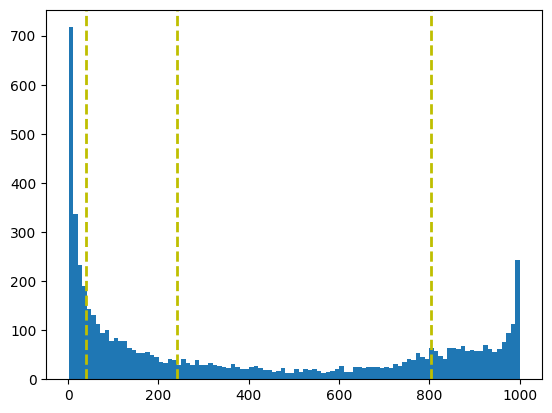

In [13]:
# Histogram for number of abstracts
dfNZ = dfIndex[dfIndex.numberPapers > 0]
plt.hist(dfNZ['numberPapers'], bins=100)

# Draw percentiles over histogram
percentiles = [0.25, 0.5, 0.75]
for p in percentiles:
    plt.axvline(dfNZ['numberPapers'].quantile(p), color='y', linestyle='dashed', linewidth=2)

Mean: 1146.57, Std: 559.09, Max: 66005, Min: 1
Percentile 10%: 571.00
Percentile 20%: 779.00
Percentile 30%: 934.00
Percentile 40%: 1059.00
Percentile 50%: 1162.00
Percentile 60%: 1256.00
Percentile 70%: 1347.00
Percentile 80%: 1450.00
Percentile 90%: 1625.00


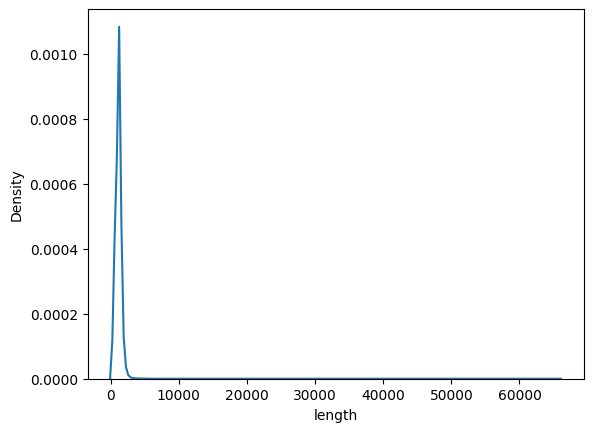

In [15]:
# Abstract length density

import seaborn as sns

sns.kdeplot(dfPapers['length'])
mean = dfPapers['length'].mean()
std = dfPapers['length'].std()
max_ = dfPapers['length'].max()
min_ = dfPapers['length'].min()

print(f"Mean: {mean:.2f}, Std: {std:.2f}, Max: {max_}, Min: {min_}")
percentiles = range(10, 100, 10)
for p in percentiles:
    q = p/100
    y = (dfPapers['length'].quantile(q))
    print(f"Percentile {p}%: {y:.2f}")

# Upper length limit: 

In [16]:
df = dfPapers[['length', 'clean_abstract']].head()
i = 0
print(df['length'])
for index, row in df.iterrows():
    print(f"Abstract {i}: {row['length']}")
    print(row['clean_abstract'])
    i += 1

0     562
1    1422
2    1301
3    1558
4     350
Name: length, dtype: int64
Abstract 0: 562
acromegaly results excessive secretion insulinlike growth factor1 growth hormone commonly occurs pituitary somatotrophinoma diagnostic features acromegaly include elevated insulinlike growth factor1 growth hormone lesion brain mri clinically dysmorphic features soft tissue swelling jaw prognathism acral overgrowth transsphenoidal resection primary therapy individuals acromegaly even cases gross total resection possible parasellar extension cavernous sinus involvement recurrent persistent disease resection systemic medications stereotactic radiosurgery used
Abstract 1: 1422
objective acromegaly disorder caused hypersecretion growth hormone gh resulting excessive levels insulinlike growth factor 1 igf1 almost always due pituitary tumor classically associated acral enlargement prominent facial features soft tissue overgrowth skin manifestations include hirsutism acne skin tags oily skin acanthosis

Count: 2278506, 99.37%


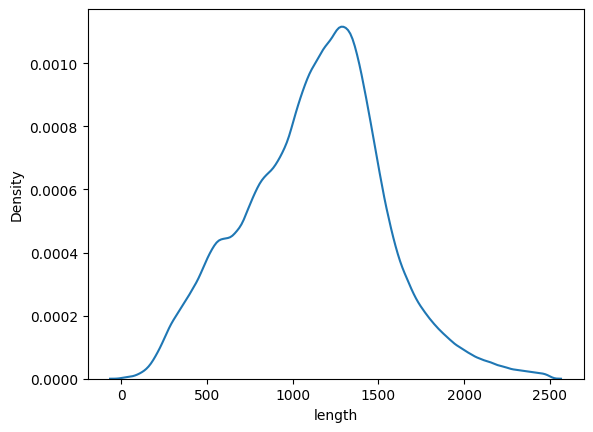

In [17]:
df2 = dfPapers[dfPapers['length'] <= 2500]
count2 = df2.shape[0]
sns.kdeplot(df2['length'])
print(f"Count: {count2}, {count2/n*100:.2f}%")

* Nº abstracts: 28 < n < Me (downsample)
* Longitud: 20 < len < 1000

In [18]:
# Percentil 95 para longitud de abstracts
pl = 0.025
pu = 0.95
lb = 20
ub = int(dfPapers['length'].quantile(pu))
print(f"LB: {lb}")
print(f"UB: Percentile {100*pu}% abstract length: {ub}")

LB: 20
UB: Percentile 95.0% abstract length: 1818


In [19]:
# Pasos para obtener traindata
# 1. Filtro por longitud: lb = 20 <= length <= ub = 1818
print("Filtrando longitud: ", lb, ub)

dfClean = dfPapers[(dfPapers['length'] >= lb) & (dfPapers['length'] <= ub)].copy()
dfIndexClean = dfNZ.copy()

countClean = dfClean.shape[0]
print(f"Abstracts escogidos: {countClean}, {countClean/n*100:.2f}%")

# nuevo index
dfIndexClean = getIndex(dfClean)
dfIndexClean.info()
print(dfIndexClean.head())
dfIndexClean['numberPapers'].describe()

Filtrando longitud:  20 1818
Abstracts escogidos: 2178409, 95.01%
<class 'pandas.core.frame.DataFrame'>
Index: 5781 entries, 0 to 5780
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   phenotypeId    5781 non-null   object
 1   numberPapers   5781 non-null   int64 
 2   phenotypeName  5781 non-null   object
dtypes: int64(1), object(2)
memory usage: 180.7+ KB
  phenotypeId  numberPapers                 phenotypeName
0  HP:0000003           640  Multicystic kidney dysplasia
1  HP:0000011           794            Neurogenic bladder
2  HP:0000012           924               Urinary urgency
3  HP:0000013           758      Hypoplasia of the uterus
4  HP:0000016           729             Urinary retention


count    5781.000000
mean      376.822176
std       356.679632
min         1.000000
25%        37.000000
50%       229.000000
75%       773.000000
max       986.000000
Name: numberPapers, dtype: float64

LB: 37.0, ME: 229.0


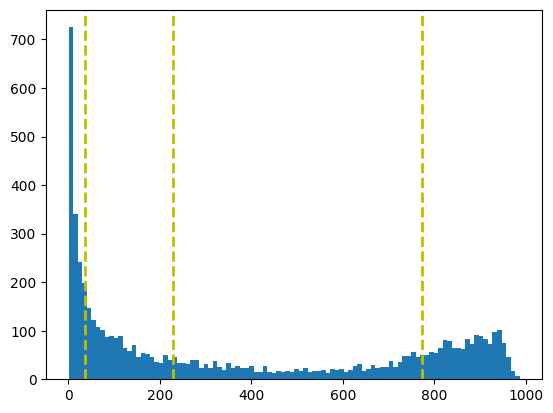

In [20]:
# 2. Filtro por nº abstracts por fenotipo: q_25 <= numberPapers <= Me (downsample)

plt.hist(dfIndexClean['numberPapers'], bins=100)

# Draw percentiles over histogram
percentiles = [0.25, 0.5, 0.75]
for p in percentiles:
    plt.axvline(dfIndexClean['numberPapers'].quantile(p), color='y', linestyle='dashed', linewidth=2)

lb = dfIndexClean['numberPapers'].quantile(0.25)
me = dfIndexClean['numberPapers'].median()

print(f"LB: {lb}, ME: {me}")

In [21]:
# filtro por abajo
dfIndexClean = dfIndexClean[dfIndexClean['numberPapers'] >= lb]
dfClean = dfClean[dfClean['phenotypeId'].isin(dfIndexClean['phenotypeId'])]
dfIndexClean.info()
dfClean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4339 entries, 0 to 5780
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   phenotypeId    4339 non-null   object
 1   numberPapers   4339 non-null   int64 
 2   phenotypeName  4339 non-null   object
dtypes: int64(1), object(2)
memory usage: 135.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2159548 entries, 22 to 2292884
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   paperId         int64 
 1   phenotypeId     object
 2   phenotypeName   object
 3   title           object
 4   clean_abstract  object
 5   length          int64 
dtypes: int64(2), object(4)
memory usage: 115.3+ MB


In [25]:
# 3. Downsampling

dfDown = pd.DataFrame()

for index, row in dfIndexClean.iterrows(): # For each phenotype
    n = row['numberPapers']
    dfAux = dfClean[dfClean['phenotypeId'] == row['phenotypeId']]
    if n > me:
        # get random sample of size n-Me
        df = resample(dfAux, replace=False, n_samples=int(me), random_state=SEED)
        # add it to new dataframe
        dfDown = pd.concat([dfDown, df])
    else:
        dfDown = pd.concat([dfDown, dfAux])


dfClean = dfDown
dfIndexClean = getIndex(dfClean)
dfIndexClean.info()
dfClean.info()        

<class 'pandas.core.frame.DataFrame'>
Index: 4339 entries, 0 to 4338
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   phenotypeId    4339 non-null   object
 1   numberPapers   4339 non-null   int64 
 2   phenotypeName  4339 non-null   object
dtypes: int64(1), object(2)
memory usage: 135.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 820515 entries, 484497 to 840924
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   paperId         820515 non-null  int64 
 1   phenotypeId     820515 non-null  object
 2   phenotypeName   820515 non-null  object
 3   title           820515 non-null  object
 4   clean_abstract  820515 non-null  object
 5   length          820515 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 43.8+ MB


In [26]:
dfIndexClean.describe()

,numberPapers
count,4339.000000
mean,189.102328
std,64.333338
min,37.000000
25%,148.000000
50%,229.000000
75%,229.000000
max,229.000000


Phenotypes with less than 229.0 abstracts: 1448, 33.37%


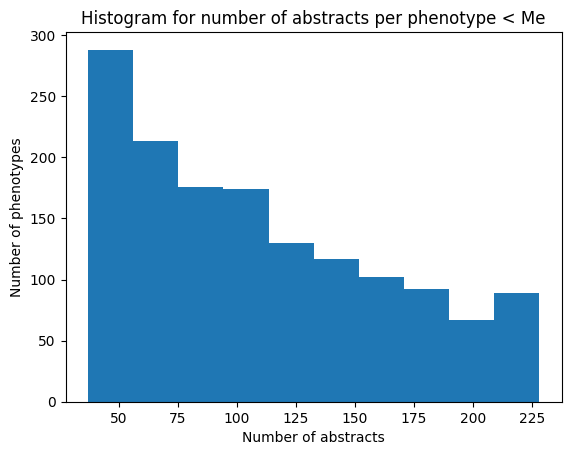

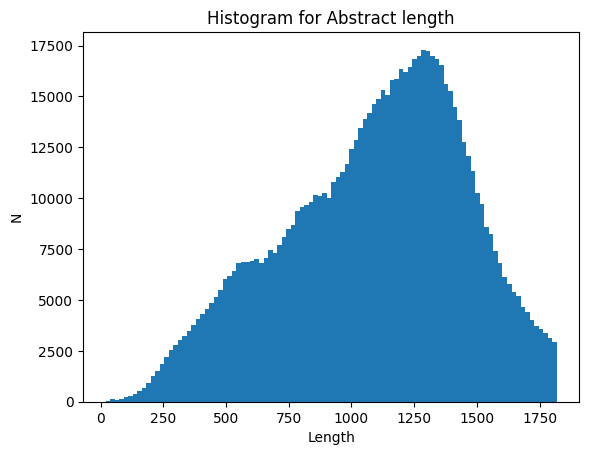

In [32]:
# 4. Final statistics
dfLower = dfIndexClean[dfIndexClean['numberPapers'] < me]
perc = dfLower.shape[0]/dfIndexClean.shape[0]*100
print(f"Phenotypes with less than {me} abstracts: {dfLower.shape[0]}, {perc:.2f}%")
plt.hist(dfLower['numberPapers'])
plt.title("Histogram for number of abstracts per phenotype (< Me)")
plt.xlabel("Number of abstracts")
plt.ylabel("Number of phenotypes")
plt.show()

plt.hist(dfClean['length'], bins=100)
plt.title("Histogram for Abstract length")
plt.xlabel("Length")
plt.ylabel("N")
plt.show()

In [116]:
# 5. Test / Train sample
# 400 NZ phenotypes left out for STS evaluation

dfPhen = pd.read_csv(PATH_DATA_FENOTIPOS, sep='\t', low_memory=False, na_values=['', nan])
testPhen = dfPhen.sample(n=400, random_state=SEED) # 400 phenotypes for test, not cleaned
testPhen = testPhen[['id', 'name']]
dfAbstractsTrain = dfClean[~dfClean['phenotypeId'].isin(testPhen['id'])]
dfIndexTrain = getIndex(dfAbstractsTrain)

left = dfIndexClean.shape[0] - dfIndexTrain.shape[0]
print(f"Phenotypes: Test - {testPhen.shape[0]} ; Train - {dfIndexTrain.shape[0]}; Left - {left}")

Phenotypes: Test - 400 ; Train - 4054; Left - 285


In [48]:
# 6. Save data
import datetime
s = datetime.today().strftime('%d-%m')

PATH_ABSTRACTS_TRAIN = PATH_DATA + '/abstracts/' + "abstracts-" + s + "-train.csv"
PATH_INDEX_TRAIN = PATH_DATA_FENOTIPOS + '/' + "index" + s + "-train.csv"
PATH_INDEX_TEST = PATH_DATA_FENOTIPOS + '/' + "index" + s + "-test.csv"

dfAbstractsTrain.to_csv(PATH_ABSTRACTS_TRAIN, sep='\t', index=False)
dfIndexTrain.to_csv(PATH_INDEX_TRAIN, sep='\t', index=False)
testPhen.to_csv(PATH_INDEX_TEST, sep='\t', index=False)

In [62]:
# 7. Train / test pairs
from datetime import datetime

s = datetime.today().strftime('%d-%m')

import math
import random
from itertools import combinations
import bisect

# get all combinations of test phenotypes

testNames = testPhen['name'].tolist()
pairs = list(combinations(testNames, 2))

from pyhpo import Ontology

# Load ontology

onto = Ontology(PATH_ONTO)

def onto_sim(name1, name2):
    phen1 = onto.get_hpo_object(name1)
    phen2 = onto.get_hpo_object(name2)
    v = phen1.similarity_score(phen2, method='lin')
    sim = min(v,1)
    return sim

ltest1, ltest2 = zip(*pairs)
goldTest = [onto_sim(pair[0], pair[1]) for pair in pairs]

dfTest = pd.DataFrame({'phenotype1': ltest1, 'phenotype2': ltest2, 'lin': goldTest})
dfTest.to_csv(PATH_EVALUATION + '/test_pairs-' + s + '.csv', sep='\t', index=False)


In [102]:
random.seed(SEED)
def random_combinations(iterable, k, size):
    "Sample n=size combinations of k elements from iterable without replacement."
    pool = tuple(iterable)
    n = len(pool)
    m = (math.comb(n,k))
    codes = random.sample(range(m), size)
    l = list()
    # Given j=code, get the j-th combination
    for code in codes:
        indices = np.array([], dtype=int)
        j = code
        for i in range(k):
            q, r = divmod(j, n-i)
            index = bisect.bisect_right(indices, r)
            r = r + index
            indices = np.insert(indices, index, r)
            j = q
        l.append(pool[i] for i in list(indices)) 
    return l

# Example
k = 2
size = 8000
l = random_combinations(dfIndexTrain['phenotypeName'], k, size)
df = pd.DataFrame(l, columns=['phenotype'+str(i) for i in range(1,k+1)])
print(df.head())

                         phenotype1  \
0                    Ankle swelling   
1  IgA deposition in the glomerulus   
2                  Median cleft lip   
3  Ovarian papillary adenocarcinoma   
4          Severe failure to thrive   

                                        phenotype2  
0                          Gallbladder dysfunction  
1                           Multiple rib fractures  
2  Decreased circulating luteinizing hormone level  
3                    Peripheral vitreous opacities  
4                           Low posterior hairline  


In [109]:
k = 2
size = 8000

lTrain = list(random_combinations(dfIndexTrain['phenotypeName'], k, size))
lTrain1, lTrain2 = zip(*lTrain)

goldTrain = []
for i in range(size):
    g = onto_sim(lTrain1[i], lTrain2[i])
    goldTrain.append(g)

dfTrain = pd.DataFrame({'phenotype1': lTrain1, 'phenotype2': lTrain2, 'lin': goldTrain})

dfTrain.to_csv(PATH_EVALUATION + '/train_pairs-' + s + '.csv', sep='\t', index=False)

In [117]:
lTest = list(random_combinations(testPhen['name'], k, size))
lTest1, lTest2 = zip(*lTest)

goldTest = []
for i in range(size):
    g = onto_sim(lTest1[i], lTest2[i])
    goldTest.append(g)

dfTest = pd.DataFrame({'phenotype1': lTest1, 'phenotype2': lTest2, 'lin': goldTest})
dfTest.to_csv(PATH_EVALUATION + '/test_pairs-' + s + '.csv', sep='\t', index=False)

Lin train distribution:
count    8000.000000
mean        0.023939
std         0.075832
min         0.000000
25%         0.000045
50%         0.000050
75%         0.000064
max         0.886708
Name: lin, dtype: float64
Lin test distribution:
count    8000.000000
mean        0.027104
std         0.080288
min         0.000000
25%         0.000043
50%         0.000048
75%         0.000087
max         1.000000
Name: lin, dtype: float64


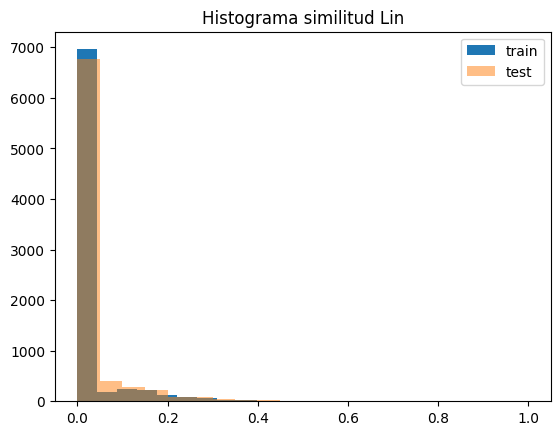

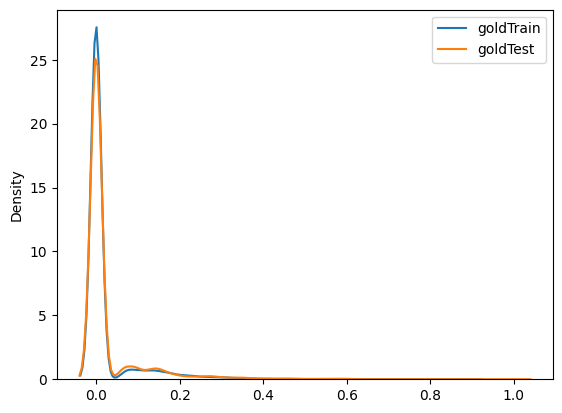

In [123]:
# Dibujar la distribución de gold train

print("Lin train distribution:")
print(dfTrain['lin'].describe())
# Dibujar la distribución de gold test

print("Lin test distribution:")
print(dfTest['lin'].describe())

plt.hist(goldTrain, bins=20, label='train')
plt.hist(goldTest, bins=20, label='test', alpha=0.5)
plt.legend()
plt.title('Histograma similitud Lin')
plt.show()

import seaborn as sns

sns.kdeplot(goldTrain, label='goldTrain')
sns.kdeplot(goldTest, label='goldTest')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()
